In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

$\frac{\partial U}{\partial t} + U\frac{\partial U}{\partial x} = 0$

In [3]:
def flux(U):
    return 0.5 * U ** 2

In [5]:
# space-derivative approximation functions
from central_diference import generate_cd
cd_2 = generate_cd(2).get_cd_as_function()
cd_4 = generate_cd(4).get_cd_as_function()
cd_6 = generate_cd(6).get_cd_as_function()
cd_8 = generate_cd(8).get_cd_as_function()

def CD_2(U, h): return -U * cd_2(U, h)
def CD_4(U, h): return -U * cd_4(U, h)
def CD_6(U, h): return -U * cd_6(U, h)
def CD_8(U, h): return -U * cd_8(U, h)

from weno import weno_5, weno_m_5, weno_z_5, weno_zm_5
def WENO_5(U, h): return -U * weno_5(U, h)
def WENO_M_5(U, h): return -U * weno_m_5(U, h)
def WENO_Z_5(U, h): return -U * weno_z_5(U, h)
def WENO_ZM_5(U, h): return -U * weno_zm_5(U, h)

In [7]:
# time-derivative approximation functions
from runge_kutta import runge_kutta_function
rk_8 = runge_kutta_function(8)

def RK_8(U, h, r, Deriv):
    dt = r * h
    return rk_8(U, dt, Deriv, (h,)), dt

In [8]:
class SolverHopf:
    def __init__(self, h, r, T = 20.):
        self.h = h
        self.r = r
        self.x = np.linspace(0, 3000, int(3000 // h) + 1)
        self.U = np.zeros_like(self.x)
        self.U_ex = np.zeros_like(self.x)
        self.T = T
    def initial(self):
        x0 = int(1480 / self.h)
        x1 = int(1520 / self.h)
        self.U[:x0] = 1.
        self.U[x1:] = -1.
        self.U[x0:x1] = -self.x[x0:x1] / 20. + 75. #np.linspace(1., -1., x1 - x0)
        if self.T < 20.:
            x0 = int(1480 / self.h) + int(self.T / self.h)
            x1 = int(1520 / self.h) - int(self.T / self.h)
            self.U_ex[:x0] = 1.
            self.U_ex[x1:] = -1.
            k = 2. / (self.x[x0] - self.x[x1])
            b = 1. - k * self.x[x0]
            self.U_ex[x0:x1] = k * self.x[x0:x1] + b #np.linspace(1., -1., x1 - x0)
        else:
            mid = int(1500. / self.h)
            self.U_ex[:mid] = 1.
            self.U_ex[mid] = 0.
            self.U_ex[mid + 1:] = -1.
    def solve(self, F, Deriv):
        self.U, dt = F(self.U, self.h, self.r, Deriv)
        Nt = int(self.T / dt)
        for i in trange(Nt):
            if i == 0: continue
            self.U, dt = F(self.U, self.h, self.r, Deriv)
    def error(self):
        x0 = int(1480 / self.h)
        x1 = int(1520 / self.h)
        intLdh = int(50 / self.h)
        return np.sqrt(np.sum((self.U[x0 - intLdh: x1 + intLdh] - self.U_ex[x0 - intLdh: x1 + intLdh]) ** 2 * self.h))
    def draw(self, axs, ylabel):
        x0 = int(1480 / self.h)
        x1 = int(1520 / self.h)
        x0 += int(self.T / self.h)
        x1 -= int(self.T / self.h)
        lim = 1.5 if self.T <= 20. else 4
        axs.set_ylim([-lim, lim])
        intLdh = int(100 / self.h)
        axs.plot(self.x[x0 - intLdh: x1 + intLdh], self.U[x0 - intLdh: x1 + intLdh], label = ylabel)
        axs.set_xlabel('x')
        axs.set_ylabel('U')
        axs.legend()
    def draw_exact(self, axs):
        x0 = int(1480 / self.h)
        x1 = int(1520 / self.h)
        x0 += int(self.T / self.h)
        x1 -= int(self.T / self.h)
        lim = lim = 1.5 if self.T <= 20. else 4
        axs.set_ylim([-lim, lim])
        intLdh = int(100 / self.h)
        axs.plot(self.x[x0 - intLdh: x1 + intLdh], self.U_ex[x0 - intLdh: x1 + intLdh], '--', label = 'exact')
        axs.set_xlabel('x')
        axs.set_ylabel('U')
        axs.legend()

In [9]:
def solve_for_different_F(H, r, T, deriv_t, deriv_x_array):
    fig = plt.figure(figsize = (20, 25))
    axs = fig.add_subplot(211)
    axs.grid()
    solver = SolverHopf(H, r, T)
    for deriv in deriv_x_array:
        solver.initial()
        solver.solve(deriv_t, deriv)
        ylabel = str(deriv_t).split(' ')[1] + '+' + str(deriv).split(' ')[1]
        solver.draw(axs, ylabel)
        print(solver.error())
    solver.draw_exact(axs)

100%|██████████| 80/80 [00:00<00:00, 258.69it/s]


3.813116698935658e-13


100%|██████████| 80/80 [00:00<00:00, 132.16it/s]


6.552526509629715e-14


100%|██████████| 80/80 [00:00<00:00, 199.93it/s]


2.831809417652678e-13


100%|██████████| 80/80 [00:00<00:00, 118.76it/s]


4.6019112657938405e-14


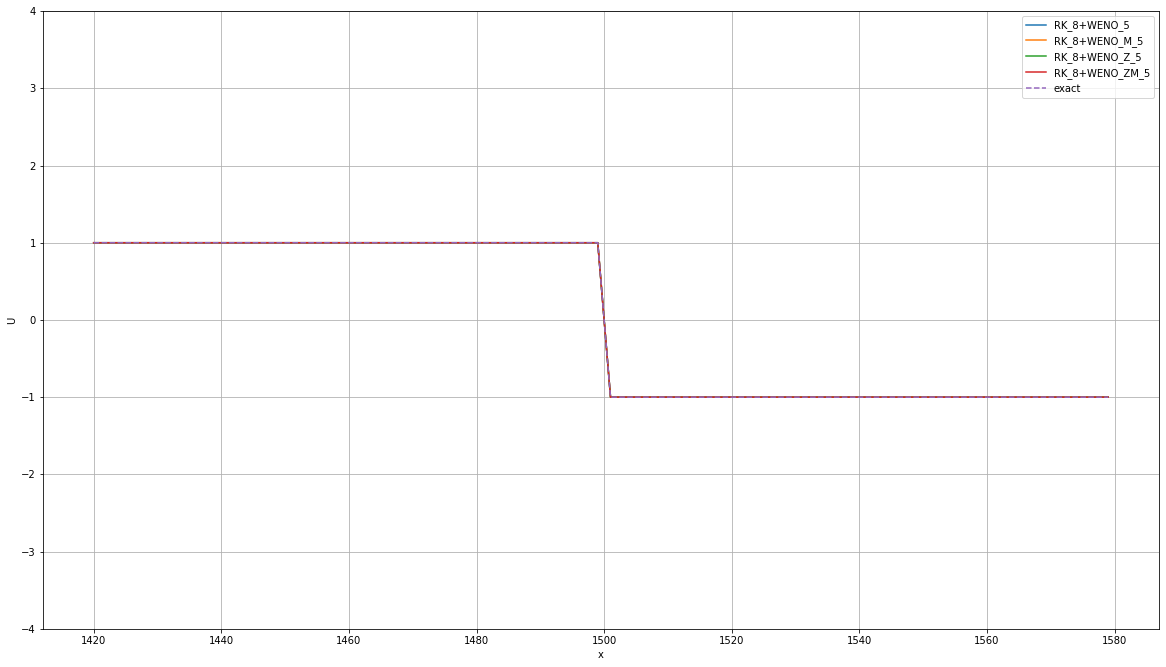

In [12]:
r = .5
T = 40.
H = 1.

#solve_for_different_F(H, r, T, RK_8, [CD_2, CD_4, CD_6, CD_8, WENO_5])
solve_for_different_F(H, r, T, RK_8, [WENO_5, WENO_M_5, WENO_Z_5, WENO_ZM_5])